# Setting up the environment

In [1]:
import os
import sys
os.path.dirname(sys.executable)

'c:\\Users\\Sanhoj\\projects\\moroccan-lpr-ocr\\venv\\Scripts'

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import EarlyStopping
from keras.layers import AveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import glob
import cv2
from livelossplot import PlotLossesKeras

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.0


``sudo apt-get install unrar``

In [3]:
from pyunpack import Archive

local_zip = 'dataset.rar'
Archive(local_zip).extractall('dataset')

In [ ]:
link = "dataset/**/**/*.*"
dataset_paths = glob.glob(link)

for image_path in dataset_paths:

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (96, 96), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_inv = cv2.bitwise_not(img)

    os. remove(image_path)

    cv2.imwrite("{}{}".format(image_path[:-4], ".png"), img)
    cv2.imwrite("{}_inverte{}".format(image_path[:-4], ".png"), img_inv)

# Visualize dataset

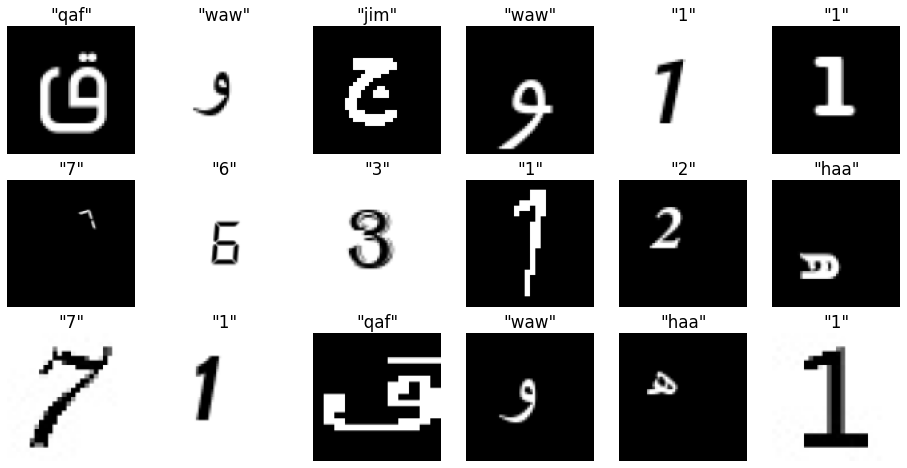

In [3]:
link = "dataset/**/**/*.*"
dataset_paths = glob.glob(link)

cols=6
rows=3

fig = plt.figure(figsize=(16, 8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols, nrows=rows, figure=fig)

np.random.seed(10)
rand = np.random.randint(0, len(dataset_paths), size=(cols*rows))

for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

# Data pre-processing

In [4]:
img_size = 96
batch_size = 64

dir_train = "dataset/train/"
dir_test  = "dataset/test/"

datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode="nearest",
                                   brightness_range= [0.5, 1.5])

train_generator = datagen_train.flow_from_directory(dir_train,
                                                    target_size=(img_size, img_size),
                                                    # color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)


datagen_validation = ImageDataGenerator(rescale=1./255)

validation_generator = datagen_validation.flow_from_directory(dir_test,
                                                    target_size=(img_size, img_size),
                                                    # color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 106130 images belonging to 19 classes.
Found 96964 images belonging to 19 classes.


# Initialize MobileNets architecture with pre-trained weight

In [5]:
def create_model(lr=1e-4, decay=1e-4/25, training=False, output_shape=19):

    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    # headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        for layer in baseModel.layers:
            layer.trainable = True

        optimizer = Adam(lr=lr, decay=decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    
        
    return model

In [10]:
epochs = 1
init_lr=1e-4

# if the model is exist
if os.path.exists("Checkpoint\model.h5"):
    print("Loading the model ...")
    model = load_model('Checkpoint\model.h5')
else:
    print("Creating the model ...")
    model = create_model(lr=init_lr, decay=init_lr/epochs, training=True)

Loading the model ...


In [11]:
model.summary()

ise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 6, 6, 64)     256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 6, 6, 384)    24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 6, 6, 384)    1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 6, 6, 384)    0           block_7_expand_BN[0][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, 6, 6, 384)    3456        block_7_expand_relu[0][0

# Train model

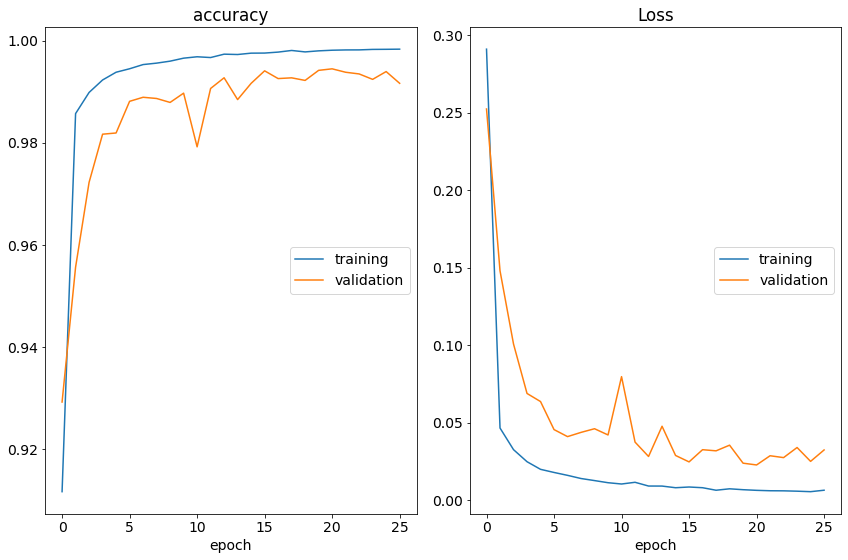

accuracy
	training         	 (min:    0.912, max:    0.998, cur:    0.998)
	validation       	 (min:    0.929, max:    0.994, cur:    0.992)
Loss
	training         	 (min:    0.005, max:    0.291, cur:    0.006)
	validation       	 (min:    0.023, max:    0.252, cur:    0.032)

Epoch 00026: saving model to checkpoint\model.h5
Epoch 00026: early stopping
Wall time: 7h 57min 35s


In [8]:
%%time

check_path = "checkpoint/model.h5"

checkpoint = ModelCheckpoint(check_path, monitor='val_accuracy', mode='max', verbose=1)
earlystoping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

my_checkpointer = [PlotLossesKeras(), checkpoint, earlystoping]

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=my_checkpointer)

# Model evaluation

In [9]:
model.evaluate(validation_generator)

1516/1516 [==============================] - 45s 30ms/step - loss: 0.0323 - accuracy: 0.9916


[0.032330624759197235, 0.9916360974311829]

In [23]:
predictions = model.predict_generator(validation_generator)
val_preds = np.argmax(predictions, axis=1)

val_trues = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

In [24]:
print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'alif', 'baa', 'dal', 'haa', 'jim', 'mim', 'qaf', 'shin', 'waw']


In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------------------------------------------------------------------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1-accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

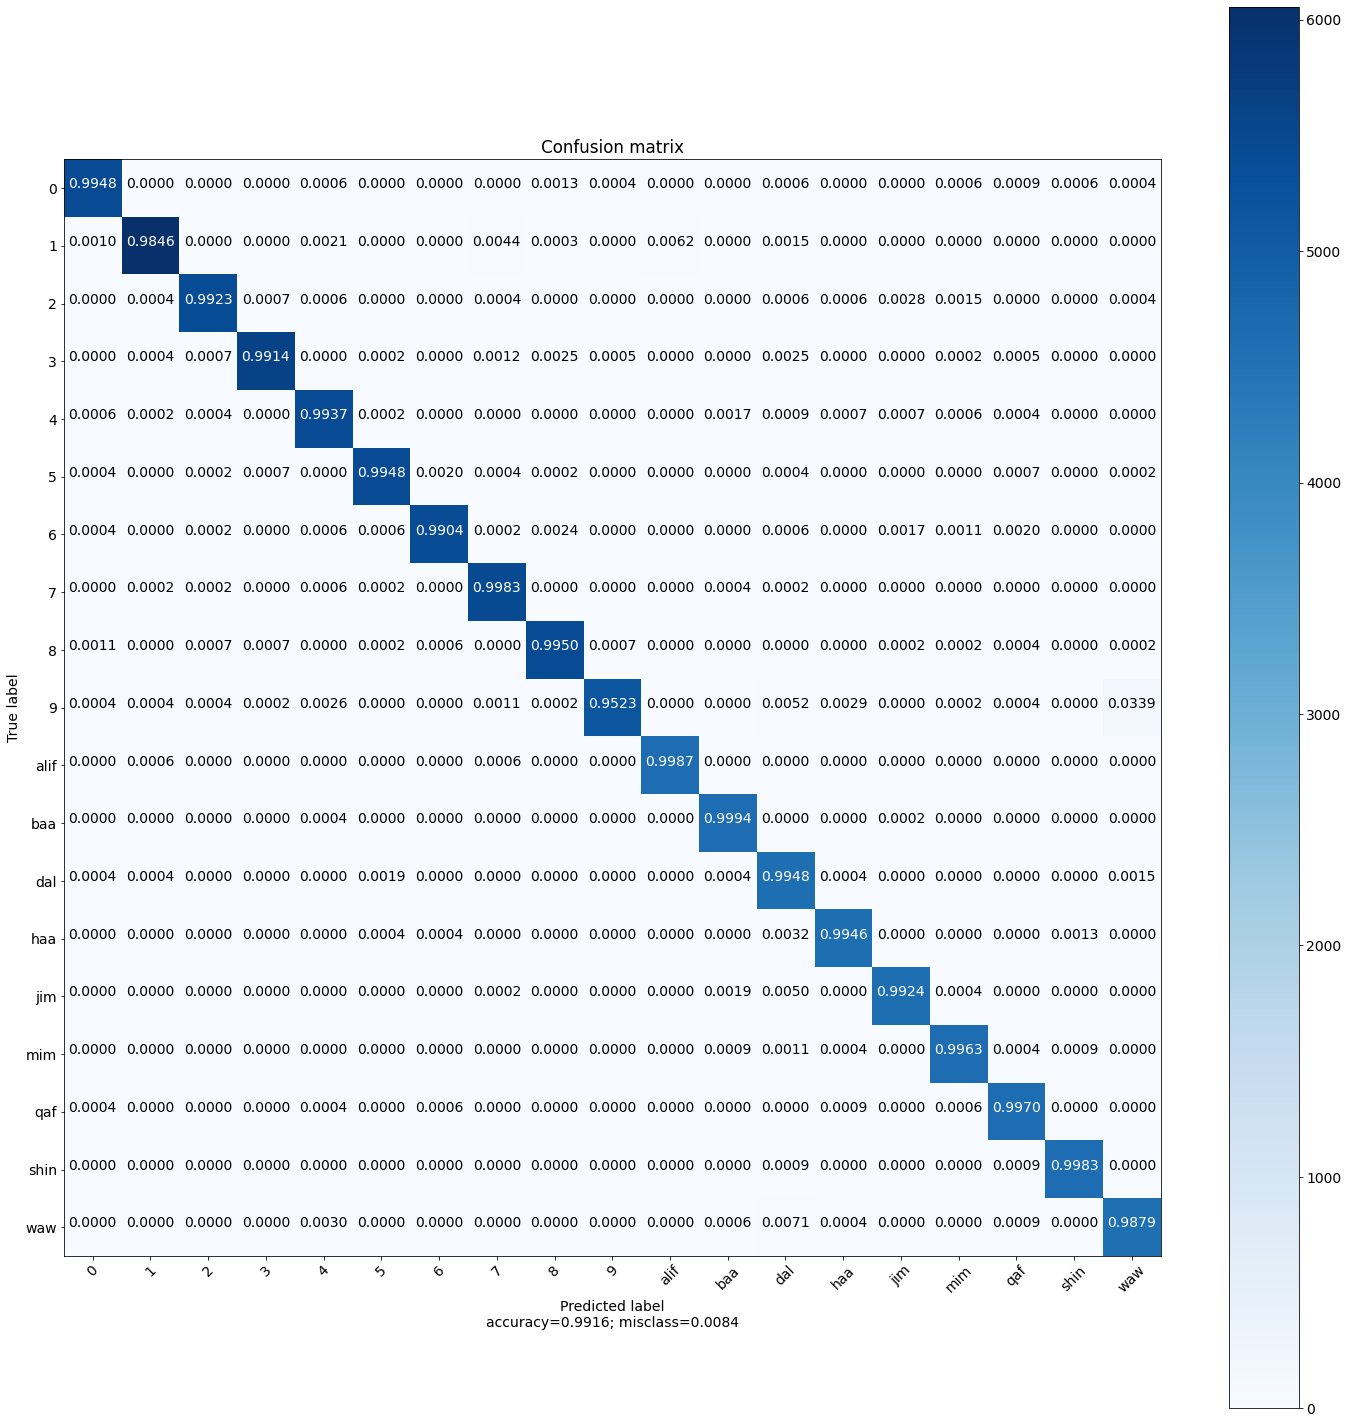

In [32]:
plot_confusion_matrix(cm=confusion_matrix(val_trues, val_preds), target_names=labels, normalize=True)

In [34]:
print(classification_report(list(val_trues), list(val_preds), target_names=labels))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5432
           1       1.00      0.98      0.99      6150
           2       1.00      0.99      0.99      5432
           3       1.00      0.99      0.99      5674
           4       0.99      0.99      0.99      5432
           5       1.00      0.99      1.00      5432
           6       1.00      0.99      0.99      5432
           7       0.99      1.00      0.99      5432
           8       0.99      1.00      0.99      5432
           9       1.00      0.95      0.97      5432
        alif       0.99      1.00      1.00      4632
         baa       0.99      1.00      1.00      4632
         dal       0.97      0.99      0.98      4632
         haa       0.99      0.99      0.99      4632
         jim       0.99      0.99      0.99      4632
         mim       0.99      1.00      1.00      4632
         qaf       0.99      1.00      0.99      4632
        shin       1.00    

# Testing with true images

In [35]:
from keras.preprocessing import image

img = image.load_img("production_images/13.png", target_size=(96, 96))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])

predictions = model.predict(images)
classe = np.argmax(predictions, axis=1)
labels = validation_generator.class_indices.keys(){}

print(predictions[0])
print(predictions[0][int(classe[0])])
print(list(labels)[int(classe[0])])

# chars[int(list(labels)[int(classe)])]

[9.98970866e-01 1.89813109e-05 8.48183754e-06 9.97016741e-07
 3.13813217e-07 2.75193270e-06 1.44594842e-05 1.24953533e-06
 3.68588844e-05 7.33982088e-05 2.29914833e-04 3.62927199e-06
 4.09344822e-04 1.08428821e-05 2.15840355e-05 4.15652539e-05
 4.80226045e-05 1.34024765e-06 1.05293606e-04]
0.99897087
0


## Thank you!